# Classifying individuals using camera trap footage.

This Jupyter notebook will show an example of using ML to do image recognition. This example uses camera trap footage from RMBL (kindly provided by Dana & Alex, thanks!). This model uses 2x 2 minute clips of camera trap footage of 2 individual marmots, 'A' and 'Bowtie'. 

On a technical level, we will use [Keras](https://keras.io/) which interfaces to [TensorFlow](https://www.tensorflow.org/), to do a classification of 3 categories:
1. Marmot 'A' in frame.
2. Marmot 'Bowtie' in frame.
3. No marmot seen.

In [3]:
# Import Keras modules and TensorFlow

from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense 
from keras import backend as K 
K.clear_session()

#import tensorflow as tf

# Import Matplotlib and pyplot and image modules

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['figure.figsize'] = [10, 10]

# Import numpy, os and skimage

import numpy as np
import os
#from skimage import exposure

Using TensorFlow backend.


### We must define some useful quantities and paths for later on. 

The img_width and img_height are the size that the input images will be compressed to. For this example it is not *so* important as the footage is all in the same format (1920x1080), but we use it to reduce overtraining.

train_data_dir and validation_data_dir are the directories of the training and testing samples. 

nb_train_samples and nb_validation_samples are the number of frames that will be used to train and test the model. 

epochs represents the number of times the training will pass over the dataset.

batch_size is the number of frames that will be processed before the model is updated. 

In [10]:
img_width, img_height = 256, 256
  
train_data_dir = '/home/matt/DockerStorage/MarmotNet/Training_Data/train/'
validation_data_dir = '/home/matt/DockerStorage/MarmotNet/Training_Data/test/'
nb_train_samples = 1000
nb_validation_samples = 400
epochs = 10
batch_size = 16
num_classes = len(os.listdir(train_data_dir))

print('{} classes found in training data directory!'.format(num_classes))

3 classes found in training data directory!


### We create a method which shows a random image from one of the training classes.

We call this 3 times, once for each class, to have a look!

In [19]:
def showexample(index):
    
    classname = os.listdir(train_data_dir)[index]

    tempdir_class = '{}/{}'.format(train_data_dir, classname)
    
    tempindex_class = int(np.random.uniform(0,len(os.listdir(tempdir_class))))
    
    templot_class = mpimg.imread('{}/{}'.format(tempdir_class, os.listdir(tempdir_class)[tempindex_class]))
    
    return templot_class, classname

Text(0.5, 0, 'Empty')

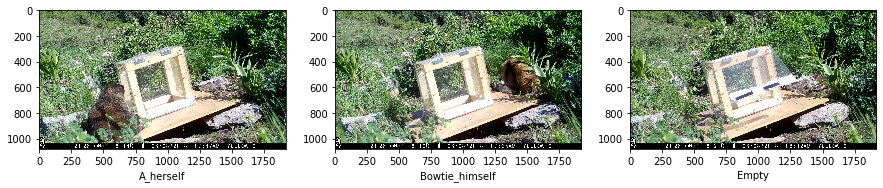

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols = 3,figsize=(15,15))
image0, label0 = showexample(0)
image1, label1 = showexample(1)
image2, label2 = showexample(2)
ax0.imshow(image0); ax0.set_xlabel(label0)
ax1.imshow(image1); ax1.set_xlabel(label1)
ax2.imshow(image2); ax2.set_xlabel(label2)

In [26]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3)

In [31]:
def CNN(num_classes):
    
    output_activation = 'softmax' if num_classes > 2 else 'sigmoid'
    
    model = Sequential() 
    model.add(Conv2D(32, (2, 2), input_shape = input_shape)) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 

    model.add(Conv2D(32, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 

    model.add(Conv2D(64, (2, 2))) 
    model.add(Activation('relu')) 
    model.add(MaxPooling2D(pool_size =(2, 2))) 

    model.add(Flatten()) 
    model.add(Dense(64)) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(num_classes)) 
    model.add(Activation(output_activation)) 
    
    return model

In [33]:
model = CNN(num_classes)
model.compile(loss ='categorical_crossentropy', optimizer ='rmsprop', metrics =['accuracy']) 

In [ ]:
train_datagen = ImageDataGenerator(
                #featurewise_center=True,
                #featurewise_std_normalization=True,
                #zca_whitening=True,
                rescale = 1. / 255, 
                shear_range = 0.2, 
                zoom_range = 0.2, 
                #horizontal_flip = True) 
)

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1. / 255) 

In [ ]:
train_generator = train_datagen.flow_from_directory(train_data_dir, 
                              target_size =(img_width, img_height), 
                     batch_size = batch_size, class_mode ='categorical')

In [ ]:
print('Will try and evaluate average image!')

index = 0
class0 = []
class1 = []
class2 = []

x, y = train_generator.next()
print(y)
while len(class0) < 500:
  image, label = x[index], y[index]
  if label[0] == 1:
    class0.append(image)
  elif label[1] == 1:
    class1.append(image)  
  #class0.append(image)
  elif label[2] == 1:
    class2.append(image)
  index += 1
  if index == batch_size:
    x, y = train_generator.next()
    index = 0

In [ ]:
train_datagen.fit(class0)
train_datagen.fit(class1)

In [ ]:
avgimage0 = np.mean(class0, axis=0)
plt.figure(0)
plt.imshow(avgimage0)
avgimage1 = np.mean(class1, axis=0)
plt.figure(1)
plt.imshow(avgimage1)
avgimage2 = np.mean(class2, axis=0)
plt.figure(2)
plt.imshow(avgimage2)

In [ ]:
plt.figure(3)
plt.imshow(avgimage1/avgimage0)
plt.figure(4)
plt.imshow(avgimage2/avgimage0)
plt.figure(5)
plt.imshow(avgimage2/avgimage1)
bkgsub = np.absolute(avgimage2 - avgimage1)

In [ ]:
plt.figure(6)
plt.imshow(bkgsub)

In [ ]:
validation_generator = test_datagen.flow_from_directory( 
                                    validation_data_dir, 
                   target_size =(img_width, img_height), 
          batch_size = batch_size, class_mode ='categorical') 

In [ ]:
x,y = train_generator.next()
for i in range(0, batch_size):
    image = x[i]
    avgimage = avgimage0 if y[i] == 0 else avgimage1
    correctedimage = np.absolute(x[i]/avgimage)
    #correctedimage = np.absolute(x[i]/avgimage0)
    label = y[i]

    fig, [(ax1, ax2, ax3), (ax4, ax5, ax6)] = plt.subplots(nrows=2,ncols=3)
    
    #plt.figure(i)
    #plt.subplot(111)
    #np.squeeze(image)
    ax1.imshow(image)
    ax2.imshow(avgimage)
    ax3.imshow(correctedimage)
    ax4.imshow(exposure.equalize_hist(image))
    ax5.imshow(exposure.rescale_intensity(exposure.equalize_hist(image)))
    ax6.imshow(np.absolute(image))
    
    plt.show()
    fig.savefig('fig{}.png'.format(i))
    if i > 10:
        break

In [ ]:
dotraining = True
if dotraining:
    history = model.fit_generator(train_generator, 
        steps_per_epoch = nb_train_samples // batch_size, 
        epochs = epochs, validation_data = validation_generator, 
        validation_steps = nb_validation_samples // batch_size) 
    
    print(history.history.keys())
    
   # plt.figure(4)
   # plt.plot(history.history['val_loss'], label='test')
   # plt.plot(history.history['loss'], label='train')
   # plt.legend(loc='best')
   # plt.xlabel('epoch')
   # plt.ylabel('Loss')
    
   # plt.figure(5)
   # plt.plot(history.history['val_accuracy'], label='test')
   # plt.plot(history.history['accuracy'], label='train')
   # plt.legend(loc='best')
   # plt.xlabel('accuracy (%)')
   # plt.ylabel('Loss')

In [ ]:
model.save('mymodel.h5')

In [ ]:
plt.figure(7)
plt.plot(history.history['val_loss'], label='test')
plt.plot(history.history['loss'], label='train')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('Loss')
    
plt.figure(8)
plt.plot(history.history['val_accuracy'], label='test')
plt.plot(history.history['accuracy'], label='train')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('Accuracy (%)')

In [ ]:
x, y = validation_generator.next()

In [ ]:
preds = model.predict(x)

In [ ]:
def decodeprediction(truth, prediction):
    
    print(truth)
    print(prediction)
    
    max = -99
    index = -99
    for i in range(len(truth)):
        if truth[i] == 1:
            print(i)
    for j in range(len(prediction)):
        if prediction[j] > max:
            max = prediction[j]
            index = j
    print(index)    
        

In [ ]:
for i in range(len(x)):
    decodeprediction(y[i], preds[i])
    plt.figure(10+i)
    plt.imshow(x[i])

In [ ]:
print(y)